#  Poverty versus services in Santiago's communes

Santiago of Chile

In [43]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/f/f4/J28_293_%C2%BBSanhattan%C2%AB.jpg")

By Osvaldo Gac Pabst  
Data Scientist

## Introduction

Santiago de Chile, is the capital and largest city of Chile as well as one of the largest cities in the Americas. It is the center of Chile's largest and most densely populated conurbation, the Santiago Metropolitan Region, whose total population is 7 million. The city is entirely located in the country's central valley. Most of the city lies between 500 m (1,640 ft) and 650 m (2,133 ft) above mean sea level.  
  
Santiago is the cultural, political and financial center of Chile and is home to the regional headquarters of many multinational corporations. The Chilean executive and judiciary are located in Santiago, but Congress meets mostly in nearby Valparaíso.  
  
The whole of Greater Santiago does not fit perfectly into any administrative division, as it extends into four different provinces and 37 **communes**. The majority of its 641.4 km2 (247.65 sq mi) (as of 2002) lie within Santiago Province, with some peripheral areas contained in the provinces of Cordillera, Maipo, and Talagante.  
  
Chile is into the 10 countries most inequality in the world, reflected in Gini’s index 0.47 in 2018, in  Santiago you can find **poor communes** and **rich communes**, nowadays difficult to understand in term of what kind of services and shops there are in each commune.  

## Business Problem

The objective of the project is to explore the possibility of, taking advantage of state of the art Machine Learning Algorithms, to segment the communes using Foursquare API to get all the venues and servicesand compare with the poverty index of each commune, to resolve the questions:  
  
**“A more poor the commune less services?”**  
  
**“What type of services characterizes the poor communes and the rich communes”**

This will help to stakeholder to decide the services they want to develop in a commune considering the lack of services per commune

To consider the problem we can list the datas as below:
-	I found the index of poverty of each commune to 2015[1]
-	I used Forsquare API to get the most common venues of given communes of Santiago[2] .
-	There are not too many maps of Santiago in geopandas or shapefile map, but not in gejson, so I built a map in geojson using the information of the bounder point in Carto Maps[3].

## Methodology

The methodology uses in the project is:
Data Collection: Principally is a secondary source get from searching on Internet and using Foursquare API
-	Search for poverty index by communes and map it to observe the different zones in Santiago. To get the data I scraping the Wikipedia page where I found a table with the information
-	I used python folium library to visualize geographic details of Santiago and how looks each communes with different index: poverty, number of services, etc.
-	Using Foursquare get the venues per communes
-	To get the segmentation is uses k-means algorithm and elbow curve to get the best number of segments
-	Analyze the correlation of the segments and the poverty index

## Data Preparation

First we need to load the libraries

In [6]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Libraries to plot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

# Maps libraries
import folium # map rendering library
from folium.plugins import MarkerCluster

# Library to scraping a web page
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


From Wikipedia I get the information of the poverty index of each communes in Santiago

In [40]:
source = requests.get('https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
from IPython.display import display_html
table_comunas = soup.find_all('table')[3]

tab_comunas = str(table_comunas)

<title>Anexo:Comunas de Santiago de Chile - Wikipedia, la enciclopedia libre</title>


I convert the html into a dataframe and explore the data.

In [8]:
dfs = pd.read_html(tab_comunas)
comunas_df=dfs[0]
print(comunas_df.dtypes)
print(comunas_df.shape)
comunas_df.head()

Comuna                                   object
Ubicación?                               object
Población (2017)?                         int64
Viviendas (2002)?                         int64
Densidad poblacional (2002) ?           float64
Crecimiento demográfico (2002-2017)?     object
ICVU (2019)?                             object
Pobreza (2015)?                         float64
dtype: object
(35, 8)


Comuna   Ubicación?  Población (2017)?  Viviendas (2002)?  \
0         Cerrillos  surponiente              80832              19811   
1       Cerro Navia  norponiente             132622              35277   
2          Conchalí        norte             126955              32609   
3         El Bosque          sur             162505              42808   
4  Estación Central  surponiente             147041              32357   

   Densidad poblacional (2002) ? Crecimiento demográfico (2002-2017)?  \
0                        4329.08                                12.9%   
1                       13482.91                               -10.7%   
2                       12070.29                                -4.4%   
3                       12270.72                                -7.3%   
4                        9036.31                                16.6%   

  ICVU (2019)?  Pobreza (2015)?  
0   47.82 (74)             19.7  
1   42.42 (92)             35.6  
2   46.52 (84)             21.6  
3   48.54 (70)             27.0  
4   49.96 (64)             14.5

As we can see, there is 38 communes in the table and the poverty index.
ICVU is a synthetic index to measure the life quality in the zone related to other zones. I will save it in other dataframe.

In [9]:
ICVU_df = comunas_df[['Comuna', 'ICVU (2019)?']]   #Define a dataframe to keep ICVU
ICVU_df.head()

Comuna ICVU (2019)?
0         Cerrillos   47.82 (74)
1       Cerro Navia   42.42 (92)
2          Conchalí   46.52 (84)
3         El Bosque   48.54 (70)
4  Estación Central   49.96 (64)

I will change the names of the columns to make easy to understand the meaning

In [10]:
comunas_df = comunas_df.rename(columns={'Ubicación?': 'Location', 'Población (2017)?': 'Population_(2017)', 
                                        'Densidad poblacional (2002) ?': 'Population_density_(2002)', 
                                        'Crecimiento demográfico (2002-2017)?' : 'Population_growth_(2002-2017)', 
                                        'Pobreza (2015)?': 'Poverty_(2015)'})
comunas_df.drop(['Viviendas (2002)?', 'ICVU (2019)?'], axis=1, inplace=True)
print(comunas_df.isnull().sum())
comunas_df.head()

Comuna                           0
Location                         0
Population_(2017)                0
Population_density_(2002)        0
Population_growth_(2002-2017)    0
Poverty_(2015)                   0
dtype: int64


Comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchalí        norte             126955   
3         El Bosque          sur             162505   
4  Estación Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty_(2015)  
0                    4329.08                         12.9%            19.7  
1                   13482.91                        -10.7%            35.6  
2                   12070.29                         -4.4%            21.6  
3                   12270.72                         -7.3%            27.0  
4                    9036.31                         16.6%            14.5

As we can see the type of the values are incorrect for the column: Population_growth_(2002-2017) , so I will create a new one and change the format to float. 

In [11]:
comunas_df['Population_growth_(2002-2017)_%'] = comunas_df['Population_growth_(2002-2017)'].map(lambda x: str(x)[:-1])
comunas_df['Population_growth_(2002-2017)_%'] = comunas_df['Population_growth_(2002-2017)_%'].str.replace(',', '.').astype(float)
print(comunas_df.dtypes)

Comuna                              object
Location                            object
Population_(2017)                    int64
Population_density_(2002)          float64
Population_growth_(2002-2017)       object
Poverty_(2015)                     float64
Population_growth_(2002-2017)_%    float64
dtype: object


Now I want to know the Santiago's total population in the analysis

In [12]:
comunas_group = comunas_df['Population_(2017)'].sum()
comunas_group

6179183

6.179.183 correspond to 88% of the population in Santiago, that is a good percentage in the analysis.  
  
Now I will get the geographical location of each commune and add to dataframe.

In [13]:
# define the dataframe columns
Comuna_loc_column = ['Comuna', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Comuna_loc = pd.DataFrame(columns=Comuna_loc_column)
print(Comuna_loc)
for Comuna in comunas_df.Comuna:
    address = Comuna + ', Santiago, Chile'
    address1 = '{}'.format(address)
    print(address1)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = None
    while(location is None):
        location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ' + Comuna + ' are {}, {}.'.format(latitude, longitude))
    Comuna_loc = Comuna_loc.append({'Comuna': Comuna, 
                                'Latitude': latitude, 
                                'Longitude': longitude}, ignore_index=True)
comunas_df = pd.merge(comunas_df, Comuna_loc, left_on = 'Comuna', right_on = 'Comuna', how = 'left')
comunas_df.head()

Empty DataFrame
Columns: [Comuna, Latitude, Longitude]
Index: []
Cerrillos, Santiago, Chile
The geograpical coordinate of Cerrillos are -33.5025026, -70.7159182841177.
Cerro Navia, Santiago, Chile
The geograpical coordinate of Cerro Navia are -33.42514465, -70.7439542419355.
Conchalí, Santiago, Chile
The geograpical coordinate of Conchalí are -33.38509635, -70.6744909389865.
El Bosque, Santiago, Chile
The geograpical coordinate of El Bosque are -33.56235185, -70.6768195592874.
Estación Central, Santiago, Chile
The geograpical coordinate of Estación Central are -33.46365825, -70.7049661863186.
Huechuraba, Santiago, Chile
The geograpical coordinate of Huechuraba are -33.36551005, -70.6432115333547.
Independencia, Santiago, Chile
The geograpical coordinate of Independencia are -33.415338, -70.6658941717999.
La Cisterna, Santiago, Chile
The geograpical coordinate of La Cisterna are -33.5295218, -70.6642528940543.
La Florida, Santiago, Chile
The geograpical coordinate of La Florida are -33.

Comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchalí        norte             126955   
3         El Bosque          sur             162505   
4  Estación Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty_(2015)  \
0                    4329.08                         12.9%            19.7   
1                   13482.91                        -10.7%            35.6   
2                   12070.29                         -4.4%            21.6   
3                   12270.72                         -7.3%            27.0   
4                    9036.31                         16.6%            14.5   

   Population_growth_(2002-2017)_%   Latitude  Longitude  
0                             12.9 -33.502503 -70.715918  
1                            -10.7 -33.425145 -70.743954  
2                             -4.4 -33.385096 -70.674491  
3                             -7.3 -33.562352 -70.676820  
4                             16.6 -33.463658 -70.704966

I will eliminate all the latin characters, because the geojson load this characters in a different way, so I will not be able to make the choropleth map

In [14]:
comunas_df = comunas_df[comunas_df['Comuna'] != 'Peñaflor']
comunas_df = comunas_df.rename(columns={'Comuna': 'comuna'})
comunas_df = comunas_df.rename(columns={'Poverty_(2015)': 'Poverty'})
comunas_df['comuna'] = comunas_df['comuna'].str.replace('í', 'i')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ó', 'o')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ñ', 'n')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('é', 'e')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('Ñ', 'N')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ú', 'u')
comunas_df['comuna'] = comunas_df['comuna'].astype(str)
comunas_df.loc[comunas_df['comuna'] == 'Padre Hurtado', 'Latitude'] = -33.5732584
comunas_df.loc[comunas_df['comuna'] == 'Padre Hurtado', 'Longitude'] = -70.8365311
comunas_df.loc[comunas_df['comuna'] == 'Lo Barnechea', 'Latitude'] = -33.35312
comunas_df.loc[comunas_df['comuna'] == 'Lo Barnechea', 'Longitude'] = -70.5150979
comunas_df.to_csv (r'E:/Study/Data Analytics/IBM Certification/Capstone Project/comunas_df.csv', index = None, header=True)
comunas_df.head()

comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchali        norte             126955   
3         El Bosque          sur             162505   
4  Estacion Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty  \
0                    4329.08                         12.9%     19.7   
1                   13482.91                        -10.7%     35.6   
2                   12070.29                         -4.4%     21.6   
3                   12270.72                         -7.3%     27.0   
4                    9036.31                         16.6%     14.5   

   Population_growth_(2002-2017)_%   Latitude  Longitude  
0                             12.9 -33.502503 -70.715918  
1                            -10.7 -33.425145 -70.743954  
2                             -4.4 -33.385096 -70.674491  
3                             -7.3 -33.562352 -70.676820  
4                             16.6 -33.463658 -70.704966

Using a bar plot, I observe which communes are the poorest and the richest.

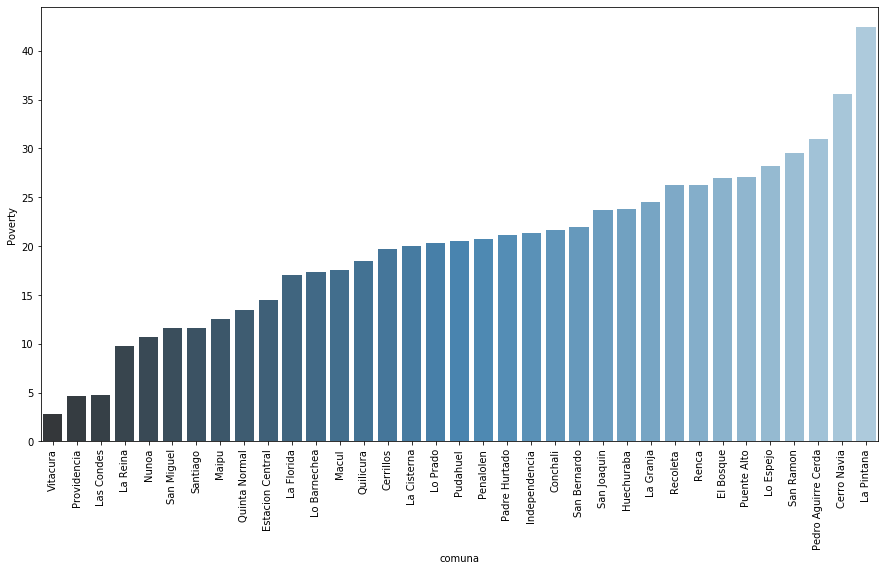

In [15]:
comunas_df.sort_values(by = ['Poverty'], inplace = True)
plt.figure(figsize=(15,8))
sns.barplot(x='comuna', y='Poverty', data=comunas_df, palette="Blues_d", capsize= 2.0)
plt.xticks(rotation=90);

We can observe the poorest communes: La Pintana and Cerro Navia. Let's do a map to see where are located this zones. 
First I create a an array to develop a a way to give a color to each poverty level.

In [16]:
# create a numpy array of length 10 and has linear spacing from the minium Proverty index to the maximum Proverty index

scale = np.linspace(comunas_df['Poverty'].min(), 
                    comunas_df['Poverty'].max(), 
                    10, dtype=int)
scale = scale.tolist() # change the numpy array to a list
scale[-1] = scale[-1] + 1 # make sure that the last value of the list is greater than the maximum of Poverty index

Let's see how is Santiago of Chile

In [17]:
# Getting the locations of the Santiango
address = 'Santiago, Santiago, Chile'
geolocator = Nominatim(user_agent="ny_explorer")
location = None
while(location is None):
    location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of ' + 'Santiago' + ' are {}, {}.'.format(latitude, longitude))

map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)
map_Santiago.save('map_Santiago.html')
map_Santiago

The geograpical coordinate of Santiago are -33.4377968, -70.6504451.


Now I load the geojson that include all the bounderies of each communes and get the latitud and longitud of Santiago.

In [41]:
# The path of the geojson file with the comuna zone
stgo_path = 'E:/Data Analytics/Data Base/Chile Maps/Comunas/Comunas_Santiago1.geojson'
print(stgo_path)

# Loading the json
with open(stgo_path, 'r') as output:
    Santiago_geojson = json.load(output)

E:/Data Analytics/Data Base/Chile Maps/Comunas/Comunas_Santiago1.geojson


Let's map the poverty index in a choropleth map

In [19]:
# let Folium determine the scale.
map_Santiago.choropleth(
    geo_data=Santiago_geojson,
    name = 'Santiago Poverty',
    data = comunas_df,
    columns=['comuna', 'Poverty'],
    key_on='feature.properties.comuna',
    threshold_scale = scale,
    fill_color= 'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Poverty 2015 by Comuna in Santiago Chile',
    reset=True
)

comunas_mark = folium.map.FeatureGroup()


for lat, lng, in zip(comunas_df.Latitude, comunas_df.Longitude):
    comunas_mark.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(comunas_df.Latitude)
longitudes = list(comunas_df.Longitude)
labels = list(comunas_df.comuna)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_Santiago)  

map_Santiago.add_child(comunas_mark)
map_Santiago.save('map_SantiagoChoro.html')
map_Santiago

C:\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The poorest zones are located to the southwest and northwest of the Santiago, and the richest zone are located to the east of Santiago.

Using the Foursquare API, I will get all the venues in each communes

In [20]:
CLIENT_ID = 'EHXMGRMV3RFFRADERZQ1MPEKD2CIUTOSCKKTEY1DU0CULNMQ' # your Foursquare ID
CLIENT_SECRET = 'W0LZBJ0UZTWB3H2DBFXBIH3VXE4X32P2PQ3PHFIYX0SKNX0Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EHXMGRMV3RFFRADERZQ1MPEKD2CIUTOSCKKTEY1DU0CULNMQ
CLIENT_SECRET:W0LZBJ0UZTWB3H2DBFXBIH3VXE4X32P2PQ3PHFIYX0SKNX0Z


In [21]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['comuna', 
                  'comuna_Latitude', 
                  'comuna_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [22]:
Santiago_venues = getNearbyVenues(names=comunas_df['comuna'],
                                   latitudes=comunas_df['Latitude'],
                                   longitudes=comunas_df['Longitude']
                                  )

Vitacura
Providencia
Las Condes
La Reina
Nunoa
San Miguel
Santiago
Maipu
Quinta Normal
Estacion Central
La Florida
Lo Barnechea
Macul
Quilicura
Cerrillos
La Cisterna
Lo Prado
Pudahuel
Penalolen
Padre Hurtado
Independencia
Conchali
San Bernardo
San Joaquin
Huechuraba
La Granja
Recoleta
Renca
El Bosque
Puente Alto
Lo Espejo
San Ramon
Pedro Aguirre Cerda
Cerro Navia
La Pintana


In [23]:
print(Santiago_venues.shape)
Santiago_venues.head()

(2583, 7)


comuna  comuna_Latitude  comuna_Longitude                       Venue  \
0  Vitacura        -33.38015        -70.565785  Club de Golf Sport Francés   
1  Vitacura        -33.38015        -70.565785              Spa One & Only   
2  Vitacura        -33.38015        -70.565785  Panadería Las Rosas Chicas   
3  Vitacura        -33.38015        -70.565785              La Chocolatine   
4  Vitacura        -33.38015        -70.565785      Centro Cultural Amanda   

   Venue_Latitude  Venue_Longitude Venue_Category  
0      -33.380146       -70.562518    Golf Course  
1      -33.382544       -70.572007            Spa  
2      -33.381580       -70.571487         Bakery  
3      -33.386412       -70.563223         Bakery  
4      -33.387675       -70.567996    Music Venue

As we can see Foursquare return 2583 venues for all communes and now I will included in a Map to see the venues

In [24]:
map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)
comunas_venues = folium.map.FeatureGroup()

for lat, lng, in zip(Santiago_venues.Venue_Latitude, Santiago_venues.Venue_Longitude):
    comunas_mark.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(Santiago_venues.Venue_Latitude)
longitudes = list(Santiago_venues.Venue_Longitude)
labels = list(Santiago_venues.Venue_Category)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_Santiago)   
    
# add incidents to map
map_Santiago.add_child(comunas_venues)
map_Santiago.save('map_SantiagoMarkVenues.html')
map_Santiago

There are too many, so I will analyse using a cluster marker to reduce the marks depending of the zoom

In [25]:
# create empty map zoomed in on Santiago
map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)


Santiago_cluster = MarkerCluster() #creating a Marker for each point in Santiago_venues. Each point will get a popup with their location

for row in Santiago_venues.itertuples():
    Santiago_cluster.add_child(folium.Marker(location=[row.Venue_Latitude,  row.Venue_Longitude],
                 popup=row.Venue))
 
map_Santiago.add_child(Santiago_cluster)
map_Santiago.save('map_SantiagoclusterVenues.html')  
map_Santiago

Now it is easier to see the venues in each commune.
And let's examine the new dataframe size.

In [26]:
Santiago_venues.groupby('comuna').count()

comuna_Latitude  comuna_Longitude  Venue  Venue_Latitude  \
comuna                                                                          
Cerrillos                         86                86     86              86   
Cerro Navia                       39                39     39              39   
Conchali                          83                83     83              83   
El Bosque                         44                44     44              44   
Estacion Central                 100               100    100             100   
Huechuraba                        45                45     45              45   
Independencia                    100               100    100             100   
La Cisterna                      100               100    100             100   
La Florida                        54                54     54              54   
La Granja                         71                71     71              71   
La Pintana                        10                10     10              10   
La Reina                          69                69     69              69   
Las Condes                       100               100    100             100   
Lo Barnechea                      83                83     83              83   
Lo Espejo                        100               100    100             100   
Lo Prado                         100               100    100             100   
Macul                            100               100    100             100   
Maipu                            100               100    100             100   
Nunoa                            100               100    100             100   
Padre Hurtado                     15                15     15              15   
Pedro Aguirre Cerda              100               100    100             100   
Penalolen                         14                14     14              14   
Providencia                      100               100    100             100   
Pudahuel                           4                 4      4               4   
Puente Alto                       86                86     86              86   
Quilicura                         44                44     44              44   
Quinta Normal                     76                76     76              76   
Recoleta                         100               100    100             100   
Renca                             24                24     24              24   
San Bernardo                      69                69     69              69   
San Joaquin                      100               100    100             100   
San Miguel                       100               100    100             100   
San Ramon                         67                67     67              67   
Santiago                         100               100    100             100   
Vitacura                         100               100    100             100   

                     Venue_Longitude  Venue_Category  
comuna                                                
Cerrillos                         86              86  
Cerro Navia                       39              39  
Conchali                          83              83  
El Bosque                         44              44  
Estacion Central                 100             100  
Huechuraba                        45              45  
Independencia                    100             100  
La Cisterna                      100             100  
La Florida                        54              54  
La Granja                         71              71  
La Pintana                        10              10  
La Reina                          69              69  
Las Condes                       100             100  
Lo Barnechea                      83              83  
Lo Espejo                        100             100  
Lo Prado                         100             100  
Macul                            

Next, let's group rows by communes and by taking the mean of the frequency of occurrence of each category

In [27]:
print('There are {} uniques categories.'.format(len(Santiago_venues['comuna'].unique())))

There are 35 uniques categories.


**Analysing each commune**

In [28]:
# one hot encoding
comuna_onehot = pd.get_dummies(Santiago_venues[['Venue_Category']], prefix="", prefix_sep="")

# add commune column back to dataframe
comuna_onehot['comuna'] = Santiago_venues['comuna'] 

# move commune column to the first column
fixed_columns = [comuna_onehot.columns[-1]] + list(comuna_onehot.columns[:-1])
comuna_onehot = comuna_onehot[fixed_columns]

comuna_onehot.head()

comuna  Airport  Airport Lounge  American Restaurant  Antique Shop  \
0  Vitacura        0               0                    0             0   
1  Vitacura        0               0                    0             0   
2  Vitacura        0               0                    0             0   
3  Vitacura        0               0                    0             0   
4  Vitacura        0               0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   ...  Vietnamese Restaurant  Vineyard  Water Park  Wine Bar  Wine Shop  \
0  ...                      0         0           0         0          0   
1  ...                      0         0           0         0          0   
2  ...                      0         0           0         0          0   
3  ...                      0         0           0         0          0   
4  ...                      0         0           0         0          0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0       0            0              0            0            0  
1       0            0              0            0            0  
2       0            0              0            0            0  
3       0            0              0            0            0  
4       0            0              0            0            0  

[5 rows x 250 columns]

And let's examine the new dataframe size

In [30]:
comuna_onehot.shape

(2583, 250)

Next, let's group rows by commune and by taking the mean of the frequency of occurrence of each category

In [32]:
comuna_grouped = comuna_onehot.groupby('comuna').mean().reset_index()
comuna_grouped

comuna   Airport  Airport Lounge  American Restaurant  \
0             Cerrillos  0.011628        0.000000             0.023256   
1           Cerro Navia  0.000000        0.000000             0.025641   
2              Conchali  0.000000        0.000000             0.012048   
3             El Bosque  0.000000        0.000000             0.000000   
4      Estacion Central  0.000000        0.000000             0.000000   
5            Huechuraba  0.000000        0.000000             0.000000   
6         Independencia  0.000000        0.000000             0.000000   
7           La Cisterna  0.000000        0.000000             0.000000   
8            La Florida  0.000000        0.000000             0.000000   
9             La Granja  0.000000        0.000000             0.000000   
10           La Pintana  0.000000        0.000000             0.000000   
11             La Reina  0.000000        0.000000             0.000000   
12           Las Condes  0.000000        0.000000             0.020000   
13         Lo Barnechea  0.000000        0.000000             0.000000   
14            Lo Espejo  0.000000        0.000000             0.010000   
15             Lo Prado  0.000000        0.000000             0.010000   
16                Macul  0.000000        0.000000             0.000000   
17                Maipu  0.000000        0.000000             0.000000   
18                Nunoa  0.000000        0.000000             0.000000   
19        Padre Hurtado  0.000000        0.000000             0.000000   
20  Pedro Aguirre Cerda  0.010000        0.000000             0.000000   
21            Penalolen  0.000000        0.000000             0.000000   
22          Providencia  0.000000        0.000000             0.010000   
23             Pudahuel  0.000000        0.000000             0.000000   
24          Puente Alto  0.000000        0.000000             0.000000   
25            Quilicura  0.000000        0.000000             0.000000   
26        Quinta Normal  0.000000        0.013158             0.000000   
27             Recoleta  0.000000        0.000000             0.010000   
28                Renca  0.000000        0.000000             0.000000   
29         San Bernardo  0.000000        0.000000             0.000000   
30          San Joaquin  0.000000        0.000000             0.000000   
31           San Miguel  0.000000        0.000000             0.000000   
32            San Ramon  0.000000        0.000000             0.000000   
33             Santiago  0.000000        0.000000             0.000000   
34             Vitacura  0.010000        0.000000             0.000000   

    Antique Shop    Arcade  Arepa Restaurant  Argentinian Restaurant  \
0       0.000000  0.011628              0.00                    0.00   
1       0.000000  0.000000              0.00                    0.00   
2       0.000000  0.012048              0.00                    0.00   
3       0.022727  0.000000              0.00                    0.00   
4       0.000000  0.000000              0.00                    0.01   
5       0.000000  0.000000              0.00                    0.00   
6       0.000000  0.010000              0.01                    0.00   
7       0.000000  0.000000              0.00                    0.00   
8       0.000000  0.000000              0.00                    0.00   
9       0.000000  0.014085              0.00                    0.00   
10      0.000000  0.000000              0.00                    0.00   
11      0.000000  0.000000              0.00                    0.00   
12      0.000000  0.000000              0.00                    0.00   
13      0.000000  0.012048              0.00                    0.00   
14      0.000000  0.010000              0.00                    0.00   
15      0.000000  0.000000              0.00                    0.01   
16      0.000000  0.000000              0.00                    0.00   
17      0.000000  0.000000              0.01            

Let's print each commune along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in comuna_grouped['comuna']:
    print("----"+hood+"----")
    temp = comuna_grouped[comuna_grouped['comuna'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cerrillos----
                    venue  freq
0          Sandwich Place  0.06
1        Department Store  0.05
2    Fast Food Restaurant  0.05
3          Ice Cream Shop  0.03
4  Furniture / Home Store  0.03


----Cerro Navia----
              venue  freq
0  Sushi Restaurant  0.08
1          Pharmacy  0.08
2            Bakery  0.08
3    Sandwich Place  0.08
4         Nightclub  0.05


----Conchali----
                    venue  freq
0        Department Store  0.06
1  Furniture / Home Store  0.05
2          Sandwich Place  0.05
3      Chinese Restaurant  0.05
4               BBQ Joint  0.04


----El Bosque----
                venue  freq
0  Chinese Restaurant  0.14
1            Pharmacy  0.09
2         Supermarket  0.09
3         Bus Station  0.07
4       Grocery Store  0.07


----Estacion Central----
                  venue  freq
0  Fast Food Restaurant  0.06
1                Bakery  0.06
2        Sandwich Place  0.05
3              Pharmacy  0.05
4      Sushi Restaurant  0.04


----

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each commune

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['comuna']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
comuna_venues_sorted = pd.DataFrame(columns=columns)
comuna_venues_sorted['comuna'] = comuna_grouped['comuna']

for ind in np.arange(comuna_grouped.shape[0]):
    comuna_venues_sorted.iloc[ind, 1:] = return_most_common_venues(comuna_grouped.iloc[ind, :], num_top_venues)

comuna_venues_sorted.head()

comuna 1st Most Common Venue   2nd Most Common Venue  \
0         Cerrillos        Sandwich Place    Fast Food Restaurant   
1       Cerro Navia              Pharmacy                  Bakery   
2          Conchali      Department Store  Furniture / Home Store   
3         El Bosque    Chinese Restaurant             Supermarket   
4  Estacion Central                Bakery    Fast Food Restaurant   

  3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0      Department Store  Furniture / Home Store             BBQ Joint   
1      Sushi Restaurant          Sandwich Place    Chinese Restaurant   
2        Sandwich Place      Chinese Restaurant                 Plaza   
3              Pharmacy             Flea Market         Grocery Store   
4        Sandwich Place                Pharmacy      Sushi Restaurant   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0        Ice Cream Shop         Deli / Bodega            Clothing Store   
1             Nightclub              Building  Bike Rental / Bike Share   
2          Soccer Field   Fried Chicken Joint                       Gym   
3           Bus Station           Pizza Place             Shopping Mall   
4    Chinese Restaurant            Restaurant            Farmers Market   

  9th Most Common Venue 10th Most Common Venue  
0      Sushi Restaurant           Liquor Store  
1            Food Truck            Supermarket  
2                   Pub              BBQ Joint  
3                 Plaza          Hot Dog Joint  
4           Pizza Place                   Pool